# **Практика 4: Атака DeepFool на модели ИИ**

Выполнил студент группы **ББМО-02-23 Курченко Иван Дмитриевич**

##**Шаги выполнения:**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Шаг 1: Загрузка обученной модели и данных MNIST**

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/drive/MyDrive/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9752 - loss: 0.0817
Test accuracy on clean images: 0.9778000116348267


### Шаг 2: Реализация атаки DeepFool с использованием Foolbox

Установка Foolbox:

In [14]:
!pip install foolbox

Реализация атаки DeepFool:

Атака происходит на последние 3 изображения

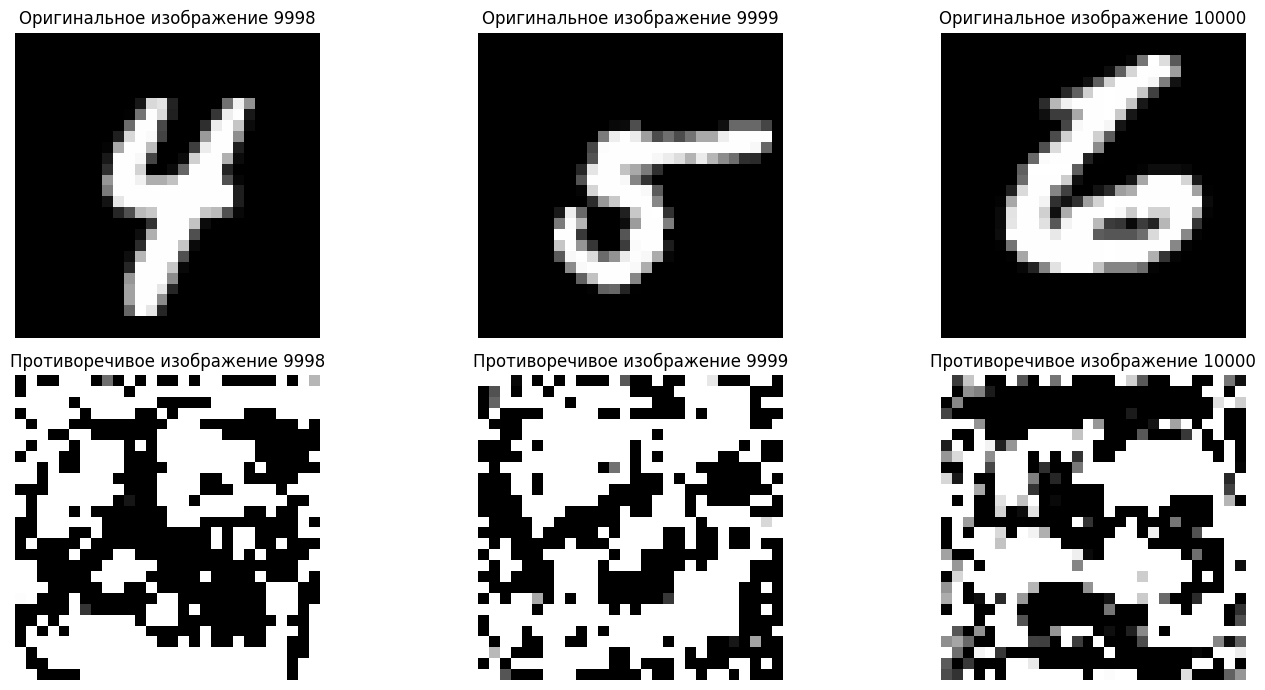

In [15]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Убедитесь, что TensorFlow импортирован

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=100)

# Количество изображений для атаки
num_images = 3

# Начать выбор с конца набора данных
start_index = len(test_images) - num_images

# Создание подграфиков для отображения результатов
plt.figure(figsize=(15, 7))

for i in range(num_images):
    # Выбор изображения для атаки
    image_index = start_index + i
    image = tf.convert_to_tensor(test_images[image_index], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[image_index])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки
    adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

    # Отображение оригинального и противоречивого изображений
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {image_index+1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {image_index+1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 3: Оценка модели на противоречивых примерах

In [16]:
import tensorflow as tf
import numpy as np

batch_size = 32
num_batches = len(test_images) // batch_size + (1 if len(test_images) % batch_size != 0 else 0)
adversarial_images = []
adversarial_labels = []

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_images))

    images_batch = tf.convert_to_tensor(test_images[start_idx:end_idx], dtype=tf.float32)
    labels_batch = np.argmax(test_labels[start_idx:end_idx], axis=1)
    labels_batch = tf.convert_to_tensor(labels_batch, dtype=tf.int64)


    advs_batch, _, success_batch = attack(fmodel, images_batch, labels_batch, epsilons=0.01)


    if tf.reduce_any(success_batch):
        adversarial_images.append(advs_batch)
        adversarial_labels.append(labels_batch)

adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_labels = tf.concat(adversarial_labels, axis=0)

num_classes = model.output_shape[-1]
adversarial_labels = tf.one_hot(adversarial_labels, depth=num_classes)


adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, adversarial_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 137.9225
Accuracy on adversarial examples (DeepFool): 0.0


###Сравнение результатов

Точность модели после атаки (accuracy): 0.0000 (0%)
Это означает, что модель не смогла правильно классифицировать ни одно из атакованных изображений. Все они были успешно изменены атакой так, что модель выдала неверный предсказанный класс.

Потери модели (loss): 137.9225
Увеличение значения функции потерь указывает на значительное отклонение выхода модели от правильных ответов. Атака DeepFool эффективно исказила входные данные, что привело к ухудшению качества классификации.